In [5]:
from understatscraper import Understat
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
import warnings
warnings.filterwarnings('ignore')
from mplsoccer.pitch import Pitch, VerticalPitch
import matplotlib.gridspec as gridspec
from selenium import webdriver
import bs4
import json
import requests
from bs4 import BeautifulSoup

In [7]:
def shotmap(match_id):
    
    #understat class
    understat = Understat()
    
    # manipulating dataframe
    df = understat.single_match(match_id)
    df[['X','Y','xG']] = df[['X','Y','xG']].apply(pd.to_numeric,axis=1)
    df['date'] = pd.to_datetime(df['date'])
    df['date'] = df['date'].dt.strftime('%Y-%m-%d')
    df['goal'] = np.where(df['result']=='Goal',1,0)
    df[['X','Y']] = df[['X','Y']]*100
    own = df[df['result']=='OwnGoal']
    df = df[df['result']!='OwnGoal']
    
    # pitch draw
    pitch = Pitch(pad_bottom=0.5,
                     goal_type='box',
                     goal_alpha=0.8,
                     pitch_type='opta',
                     pitch_color='#263a4d')
    
    # plotting figures
    fig, ax = pitch.draw(figsize=(14, 12))
    fig.patch.set_facecolor('#263a4d')

    # creating scatter plots for home & away teams 
    re = pitch.scatter(100-df[(df['h_a']=='h') & (df['result']=='Goal')]['X'],
                       100-df[(df['h_a']=='h') & (df['result']=='Goal')]['Y'],
                       s=(df[(df['h_a']=='h') & (df['result']=='Goal')]['xG']*720)+100,
                       c='#c9897b',marker='h',edgecolors='#383838',ax=ax,label='Goal'
                      )

    re1 = pitch.scatter(100-df[(df['h_a']=='h') & (df['result']!='Goal')]['X'],
                        100-df[(df['h_a']=='h') & (df['result']!='Goal')]['Y'],
                        s=(df[(df['h_a']=='h') & (df['result']!='Goal')]['xG']*720)+100,
                        c='#808080',marker='h',edgecolors='#383838',ax=ax,label='Missed'
                       )

    re2 = pitch.scatter(df[(df['h_a']=='a') & (df['result']=='Goal')]['X'],
                        df[(df['h_a']=='a') & (df['result']=='Goal')]['Y'],
                        s=(df[(df['h_a']=='a') & (df['result']=='Goal')]['xG']*720)+100,
                        c='#c9897b',marker='h',edgecolors='#383838',ax=ax,label='Goal'
                       )

    re3 = pitch.scatter(df[(df['h_a']=='a') & (df['result']!='Goal')]['X'],
                        df[(df['h_a']=='a') & (df['result']!='Goal')]['Y'],
                        s=(df[(df['h_a']=='a') & (df['result']!='Goal')]['xG']*720)+100,
                        c='#808080',marker='h',edgecolors='#383838',ax=ax,label='Missed'
                       )

    re4 = pitch.scatter(own[(own['h_a']=='a') & (own['result']=='OwnGoal')]['X'],
                        own[(own['h_a']=='a') & (own['result']=='OwnGoal')]['Y'],
                        s=(own[(own['h_a']=='a') & (own['result']=='OwnGoal')]['xG']*720)+100,
                        c='#9e443e',marker='h',edgecolors='#383838',ax=ax
                       )

    re5 = pitch.scatter(100-own[(own['h_a']=='h') & (own['result']=='OwnGoal')]['X'],
                        100-own[(own['h_a']=='h') & (own['result']=='OwnGoal')]['Y'],
                        s=(own[(own['h_a']=='h') & (own['result']=='OwnGoal')]['xG']*720)+100,
                        c='#9e443e',marker='h',edgecolors='#383838',ax=ax
                       )

    # adding legends depends on goal or own goal
    if len(own)!=0:
        colors = ['#9e443e','#808080','#c9897b']
        for y,c in zip(np.arange(5, 20, 5).tolist(),colors):
            plt.scatter(90,y,s=300,color=c,marker='h')
   
        xx = np.arange(93, 96, 1).tolist()[::-1]
        yy = np.arange(5, 20, 5).tolist()
        xx_yy = ['Own Goal', 'Missed', 'Goal']
        for i in range(len(xx)):
            plt.text(xx[i], yy[i], xx_yy[i], fontsize=12, color="white",ha="center", va="center",fontweight='bold')
    
    else:
        colors = ['#808080','#c9897b']
        for y,c in zip(np.arange(10, 20, 5).tolist(),colors):
            plt.scatter(90,y,s=300,color=c,marker='h')
        
        xx = np.arange(93, 95, 1).tolist()
        yy = np.arange(10, 20, 5).tolist()[::-1]
        xx_yy = ['Goal', 'Missed']
        for i in range(len(xx)):
            plt.text(xx[i], yy[i], xx_yy[i], fontsize=12, color="white",ha="center", va="center",fontweight='bold')

    # adding xG sizes
    mSize = [0.10,0.2,0.4,0.6,0.8]
    mSizeS = [720 * i for i in mSize]
    mSizeS = [100 + i for i in mSizeS]

    mx = [3,3,3,3,3]
    my = [1.8,4,6.8,10,13.75]

    plt.scatter(mx,my,s=mSizeS,edgecolor='black',marker='h')
    for i in range(len(mx)):
        plt.text(mx[i]+3.2,my[i],mSize[i],fontsize=12,c='white',ha='center',va='center',fontweight='bold')

    plt.figtext(0.0825,0.25,'xG',fontweight='bold',fontsize=12,color='white')
    
    # adding xG, conversion and xG per Shot circles
    h_xg = sum(df[df['h_a']=='h']['xG'])
    a_xg = sum(df[df['h_a']=='a']['xG'])
    lst_xg = [h_xg,a_xg]

    h_conversion = len(df[(df['result']=='Goal') & (df['h_a']=='h')])/len(df[df['h_a']=='h'])
    a_conversion = len(df[(df['result']=='Goal') & (df['h_a']=='a')])/len(df[df['h_a']=='a'])
    lst_conversion = [h_conversion,a_conversion]

    h_xg_shot = h_xg/len(df[df['h_a']=='h'])
    a_xg_shot = a_xg/len(df[df['h_a']=='a'])
    lst_xg_shot = [h_xg_shot,a_xg_shot]

    for x,xg in zip(np.arange(0.4,0.601,0.2).tolist(),lst_xg):
        plt.text(x, 0.8450, "xG: {:.2f}".format(xg), size=20,
         ha="center", va="center",transform=ax.transAxes,
         color="#ff6361",fontweight='bold',
         bbox=dict(boxstyle="circle",color='#ff6361',alpha=0.10)
         )
    
    for x,con in zip(np.arange(0.4,0.601,0.2).tolist(),lst_conversion):
        plt.text(x, 0.6550, "Conversion: {:.2f}".format(con), size=10.5,
         ha="center", va="center",transform=ax.transAxes,
         color="#baffc9",fontweight='bold',
         bbox=dict(boxstyle="circle",color='#baffc9',alpha=0.10)
         )
    
    for x,xg_shot in zip(np.arange(0.4,0.601,0.2).tolist(),lst_xg_shot):
        plt.text(x, 0.4650, "xG per Shot: {:.2f}".format(xg_shot), size=10,
         ha="center", va="center",transform=ax.transAxes,
         color="#ffffba",fontweight='bold',
         bbox=dict(boxstyle="circle",color='#ffffba',alpha=0.10)
         )
        
    # preparing title
    h_goal = len(df[(df['result']=='Goal') &(df['h_a']=='h')]) + len(own[(own['result']=='OwnGoal') & (own['h_a']=='a')])
    a_goal = len(df[(df['result']=='Goal') &(df['h_a']=='a')]) + len(own[(own['result']=='OwnGoal') & (own['h_a']=='h')])
    font = {'family': 'Comic Sans MS',
       'color': 'black',
       'weight': 'bold',
       'size': 16
       }
    plt.title(df['date'].values[0] + " | " + df['h_team'].values[0] + '-' + df['a_team'].values[0] + ': ' + str(h_goal) + "-"+
          str(a_goal)+ " | " + "Shot Map",fontdict=font,color='white')
    
    # adding figtext
    #plt.figtext(0.03,0.85,'@seripenaltilar',fontweight='bold',fontsize=12,color='white')
    
    # show the plot
    plt.show()

In [8]:
def xg_flow(match_id):
    #understat class
    understat = Understat()
    
    # cleaning data
    df = understat.single_match(match_id)
    df[['X','Y','xG']] = df[['X','Y','xG']].apply(pd.to_numeric,axis=1)
    df['date'] = pd.to_datetime(df['date'])
    df['date'] = df['date'].dt.strftime('%Y-%m-%d')
    df['minute'] = df['minute'].astype(int)
    df[['X','Y']] = df[['X','Y']]*100
    own = df[df['result']=='OwnGoal']
    own['result'] = np.where(own['result']=='OwnGoal','Goal',own['result'])
    df_h = pd.concat([df[(df['h_a']=='h') & (df['result']!='OwnGoal')],own[own['h_a']=='a']])
    df_a = pd.concat([df[(df['h_a']=='a') & (df['result']!='OwnGoal')],own[own['h_a']=='h']])
    df_h = df_h.sort_values(by='minute')
    df_a = df_a.sort_values(by='minute')
    df_h['xg_cumulative'] = df_h['xG'].cumsum()
    df_a['xg_cumulative'] = df_a['xG'].cumsum()
    
    # preparing lists for step and scatter plot
    h_min = df_h['minute'].tolist()
    h_min.insert(0,0)
    a_min = df_a['minute'].tolist()
    a_min.insert(0,0)
    h_xg = df_h['xg_cumulative'].tolist()
    h_xg.insert(0,0.0)
    a_xg = df_a['xg_cumulative'].tolist()
    a_xg.insert(0,0.0)

    # preparing last items in the list
    if max(h_min) > max(a_min) and max(h_min)>=90:
        a_min.append(max(h_min))
        a_xg.append(max(a_xg))   
    elif max(a_min) > max(h_min) and max(a_min)>=90:
        h_min.append(max(a_min))
        h_xg.append(max(h_xg))
    else:
        h_min.append(90)
        a_min.append(90)
        h_xg.append(max(h_xg))
        a_xg.append(max(a_xg)) 
 
    # creating figure
    fig,ax = plt.subplots(figsize=(18,8))
    
    # step graphs
    ax.step(x=h_min,y=h_xg,c="#fec668",linewidth=5,where='post')
    ax.step(x=a_min,y=a_xg,c="#bc5090",linewidth=5,where='post')
    
    # customizing graph
    ax.set_facecolor(color='#263a4d')
    ax.grid(b = True, color ='grey',
            linestyle ='-.', linewidth = 2,
            alpha = 0.4)
    ax.spines[['left','bottom','right','top']].set_color('grey')
    fig.patch.set_facecolor('#263a4d')
    
    # scatter plots
    ax.scatter(x=df_h[df_h['result']=='Goal']['minute'],y=df_h[df_h['result']=='Goal']['xg_cumulative'],s=900,
          color='#fec668', edgecolor='black', label=df_h['h_team'].iloc[0],linewidths=1.5)

    ax.scatter(x=df_a[df_a['result']=='Goal']['minute'],y=df_a[df_a['result']=='Goal']['xg_cumulative'],s=900,
          color='#bc5090', edgecolor='black', label=df_a['a_team'].iloc[0],linewidths=1.5)
    
    # legends
    legend = ax.legend(loc="upper center",prop={'weight':'bold'})
    legend.legendHandles[0]._sizes = [1000]
    legend.legendHandles[1]._sizes = [1000]

    # Annotation for players who scored

    #home team
    for i in range(len(df_h[(df_h['result']=='Goal') & (df_h['xG'] != 0)])):
        ax.annotate(df_h[(df_h['result']=='Goal') & (df_h['xG'] != 0)]['player'].tolist()[i], 
                 (df_h[(df_h['result']=='Goal') & (df_h['xG'] != 0)]['minute'].tolist()[i]-2.5,
                  df_h[(df_h['result']=='Goal') & (df_h['xG'] != 0)]['xg_cumulative'].tolist()[i]+0.20),
                c='white',size=13)

    # away team  
    for i in range(len(df_a[(df_a['result']=='Goal') & (df_a['xG'] != 0)])):
        ax.annotate(df_a[(df_a['result']=='Goal') & (df_a['xG'] != 0)]['player'].tolist()[i], 
                 (df_a[(df_a['result']=='Goal') & (df_a['xG'] != 0)]['minute'].tolist()[i]-2.5,
                  df_a[(df_a['result']=='Goal') & (df_a['xG'] != 0)]['xg_cumulative'].tolist()[i]+0.20),
                c='white',size=13)

    # own goal away team
    for i in range(len(df_a[(df_a['result']=='Goal') & (df_a['xG'] == 0)])):
        ax.annotate('Own Goal', 
                 (df_a[(df_a['result']=='Goal') & (df_a['xG'] == 0)]['minute'].tolist()[i]-2.5,
                  df_a[(df_a['result']=='Goal') & (df_a['xG'] == 0)]['xg_cumulative'].tolist()[i]+0.20),
                c='white',size=13)
    
    # own goal home team   
    for i in range(len(df_h[(df_h['result']=='Goal') & (df_h['xG'] == 0)])):
        ax.annotate('Own Goal', 
                 (df_h[(df_h['result']=='Goal') & (df_h['xG'] == 0)]['minute'].tolist()[i]-2.5,
                  df_h[(df_h['result']=='Goal') & (df_h['xG'] == 0)]['xg_cumulative'].tolist()[i]+0.20),
                c='white',size=13)

    # Annotations for xGs

    # home team
    for i in range(len(df_h[df_h['result']=='Goal'])):
        plt.annotate(np.round(df_h[df_h['result']=='Goal']['xG'],2).tolist()[i], 
                 (df_h[df_h['result']=='Goal']['minute'].tolist()[i], 
                  df_h[df_h['result']=='Goal']['xg_cumulative'].tolist()[i]),c='white',
                 size=11,ha='center',va='center',fontweight='bold')

    # away team
    for i in range(len(df_a[df_a['result']=='Goal'])):
        plt.annotate(np.round(df_a[df_a['result']=='Goal']['xG'],2).tolist()[i], 
                 (df_a[df_a['result']=='Goal']['minute'].tolist()[i], 
                  df_a[df_a['result']=='Goal']['xg_cumulative'].tolist()[i]),c='white',
                 size=11,ha='center',va='center',fontweight='bold')
    
    # fonts for labels, axis and title
    font = {'family': 'Comic Sans MS',
       'color': 'white',
       'weight': 'bold',
       'size': 16
       }

    plt.xlabel('Minute',fontdict=font)
    plt.ylabel('Expected Goal', fontdict=font)

    plt.vlines( ymin=0, ymax=max(max(df_h['xg_cumulative']),max(df_a['xg_cumulative']))+0.5,x=45, alpha = 0.7,color='#c9897b',linestyle="solid")

    plt.xticks([0,15,30,45,60,75,90],c='white',fontsize=16)
    plt.yticks(c='white',fontsize=16)
    plt.margins(y=0.005)
    plt.title(df['date'].iloc[0] + ' | ' + df_h['h_team'].iloc[0] + ' - ' + df_a['a_team'].iloc[0] + ' | ' + 
              'Expected Goal Flow' ,fontdict=font)
    #plt.figtext(0.12,0.9,'@seripenaltilar',fontweight='bold',fontsize=12,color='white')

    plt.show()

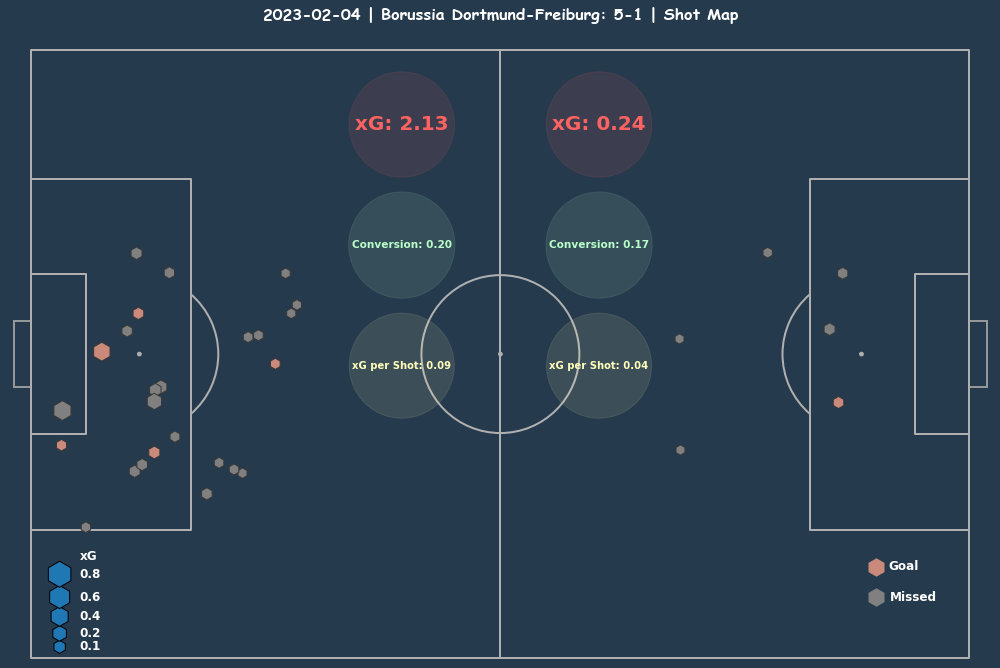

In [18]:
shotmap(19504)

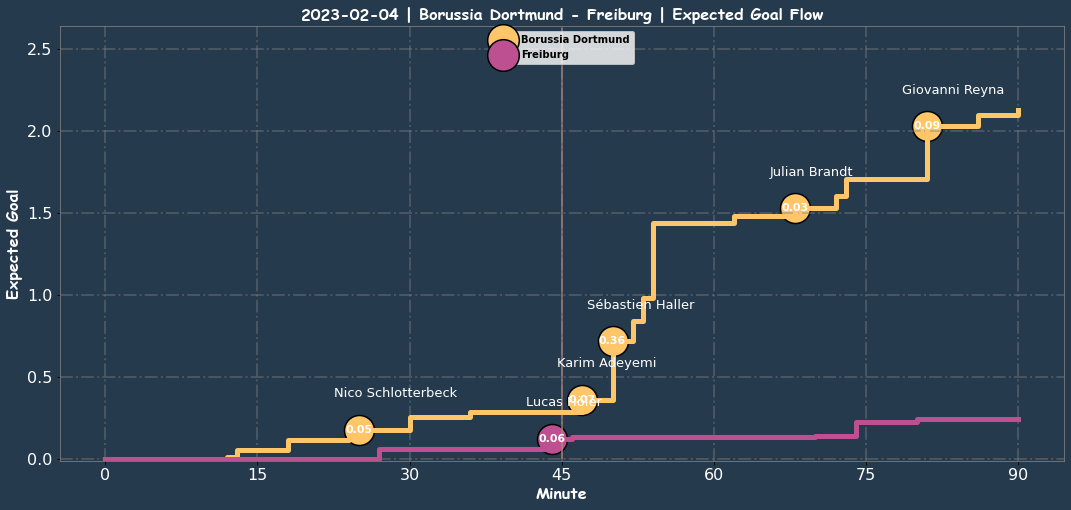

In [17]:
xg_flow(19504)